In [50]:
import tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn
import cv2
import os
import matplotlib.pyplot as plt

In [51]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

(64, 64, 3)


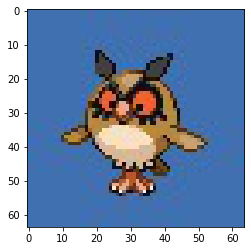

In [52]:
from os import listdir
from os.path import isfile, join
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array 
import imageio

source_path = 'jpeg'
img_files = [f for f in listdir(source_path) if isfile(join(source_path, f))]

x_imgs = []
for file in img_files:
    if file[0] != '.':
        target_img_path = source_path + '/' + file 
        img = load_img(target_img_path)
        img = img_to_array(img)
        #img = cv2.resize(img, (100, 100))  # take out for homework should be 64, 64
        #img = img/255.0 
        x_imgs.append(img/255.0)

import matplotlib.pyplot as plt 
plt.imshow(x_imgs[0]) 
print(x_imgs[0].shape)


In [53]:
X = np.array(x_imgs)
X.shape

(2240, 64, 64, 3)

In [54]:
#####
tensorflow.keras.backend.clear_session()

In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPool2D,Input,BatchNormalization,Lambda,Reshape,Conv2DTranspose

In [56]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [65]:
latent_dim = 50

encoder_inputs = Input((64,64,3))
x = Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same')(encoder_inputs)
x = Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(x)
x = Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(x)
#x = MaxPool2D((2,2))(x)
x = Flatten()(x)
x = Dense(units=128,activation='relu')(x)
z_mean = Dense(latent_dim,activation='relu',name='zmean')(x)
z_log_var = Dense(latent_dim,activation='relu',name='zlogvar')(x)
z = Sampling()([z_mean,z_log_var])

encoder = Model(encoder_inputs,[z_mean,z_log_var,z])
encoder.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 32)   896         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_4[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 32)   0           conv2d_5[0][0]                   
_______________________________________________________________________________________

In [66]:
latent_inputs = Input(shape=(latent_dim,))
x = Dense(64 * 64 * 16, activation="relu")(latent_inputs)
x = Reshape((64, 64, 16))(x)
x = Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu",padding="same")(x)
x = Conv2DTranspose(16, 3, activation="relu",padding="same")(x)
decoder_outputs = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 65536)             3342336   
_________________________________________________________________
reshape_4 (Reshape)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 64, 64, 64)        9280      
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 64, 64, 16)        4624      
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 64, 64, 3)         435 

In [67]:
class VAE(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super(VAE,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tensorflow.keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tensorflow.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tensorflow.keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [self.total_loss_tracker,self.reconstruction_loss_tracker,self.kl_loss_tracker]
    
    def train_step(self,data):
        with tf.GradientTape() as tape:
            z_mean,z_log_var,z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(data,reconstruction), axis=(1,2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss,self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [68]:
vae = VAE(encoder,decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(X, epochs=4)

Epoch 1/4
70/70 [==============================] - 39s 560ms/step - loss: 2739.7270 - reconstruction_loss: 2690.5989 - kl_loss: 7.2935
Epoch 2/4
70/70 [==============================] - 42s 595ms/step - loss: 2643.5374 - reconstruction_loss: 2633.9097 - kl_loss: 10.3869
Epoch 3/4
70/70 [==============================] - 41s 592ms/step - loss: 2621.2119 - reconstruction_loss: 2606.5178 - kl_loss: 13.8724
Epoch 4/4
70/70 [==============================] - 41s 590ms/step - loss: 2602.7052 - reconstruction_loss: 2590.0503 - kl_loss: 15.0572


In [37]:
vae.save_weights('face_vae_weights.h5')

In [38]:
vae = VAE(encoder,decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.built = True
vae.load_weights('face_vae_weights.h5')

In [39]:
# SAVING ARCHITECTURE
import pickle

with open('VAE_face.pickle','wb') as file:
    pickle.dump(VAE,file)

In [40]:
## PREDICTIONS

In [41]:
import random as raa
r = []
for i in range(50):
    rand = raa.uniform(-1,5)
    r.append(rand)
r = np.array(r)

r = r.reshape((1,50))
random_vectors = np.random.normal(loc=0, scale=1, size=(1, 50))
random_vectors *=r
pred = vae.decoder.predict(r)

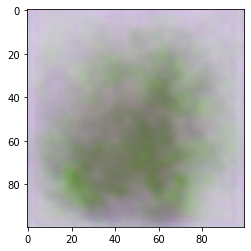

In [42]:
plt.imshow(pred[0].reshape((100,100,3)))

In [43]:
existing = X[88]
pred = vae.encoder.predict(existing.reshape((1,100,100,3)))
pred = pred[2]
predd = vae.decoder.predict(pred)

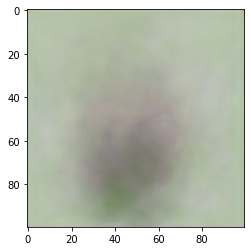

In [44]:
plt.imshow(predd.reshape((100,100,3)))

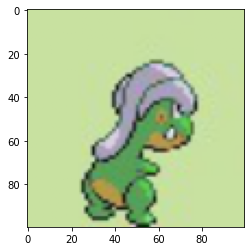

In [45]:
plt.imshow(existing.reshape((100,100,3)))

In [46]:
pred

array([[ 0.23874693,  1.5582334 ,  0.5534609 ,  0.6260896 ,  2.3343577 ,
        -0.9642607 ,  0.5946578 ,  1.1279444 , -0.89570487, -0.30979487,
         0.3279715 ,  3.859405  ,  0.89382386, -1.6251531 ,  1.1846157 ,
         0.7755551 ,  1.0535905 ,  2.8824384 ,  0.26938426, -0.2551626 ,
        -1.9342299 ,  1.0573571 , -0.8296325 ,  0.8566201 ,  0.6750504 ,
         3.7614155 ,  1.4755347 ,  2.131992  , -0.04907149,  0.53271407,
         1.2703255 ,  1.1646479 , -0.513333  ,  0.66015685, -0.91807044,
        -0.4089197 , -0.51193106,  1.7497678 ,  0.90849364, -0.34728858,
         0.6753706 ,  0.26300806,  2.421292  , -0.3198685 , -1.0981146 ,
         1.4575977 ,  0.5776451 ,  2.7754154 , -0.31500936,  0.25247023]],
      dtype=float32)

In [49]:
z_sample = np.array([[-1000.0, 1000.0]])
#z_sample = np.array([np.random.rand(2)])
print(z_sample)
x_decoded = decoder.predict(z_sample)
digit = x_decoded[0].resahpe(64, 64)
plt.imshow(digit, cmap='Greys_r')
plt.show()


[[-10.  10.]]


ValueError: in user code:

    C:\Users\sbing\.conda\envs\Tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\sbing\.conda\envs\Tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\sbing\.conda\envs\Tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\sbing\.conda\envs\Tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\sbing\.conda\envs\Tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\sbing\.conda\envs\Tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\sbing\.conda\envs\Tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\sbing\.conda\envs\Tensorflow\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\sbing\.conda\envs\Tensorflow\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\Users\sbing\.conda\envs\Tensorflow\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\sbing\.conda\envs\Tensorflow\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\sbing\.conda\envs\Tensorflow\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer dense_1 is incompatible with the layer: expected axis -1 of input shape to have value 50 but received input with shape [None, 2]
